# This is the analysis that has been used in the paper. 

## Code Setup

In [1]:
# Path to main directory
LOCAL_PATH = "data/CA-EcoScape-Paper"
DATA_PATH = LOCAL_PATH

In [2]:
import os
import pandas as pd
import numpy as np
import sys
from IPython.core.display import HTML

In [3]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "birdmaps"))

In [4]:
# Installs required packages
import bird_runs 

## Bird Run Definition

In [5]:

bird_run = bird_runs.BirdRun(DATA_PATH)

birds = []

NUM_SIMULATIONS = 400
TRANSMISSION_EXPONENT = 1
NUM_SPREADS = [2, 4, 6, 8, 10, 15, 20, 30, 40]
HOPS = [1, 2, 3, 4, 5, 6]
RUN_NAME = "Jun8"

for hop_distance in HOPS:
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "acowoo", "Acorn Woodpecker",
            do_validation=True, run_name=RUN_NAME,
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS,
            transmission_exponent=TRANSMISSION_EXPONENT))

for hop_distance in HOPS:
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "stejay", "Steller's Jay",
            do_validation=True, run_name=RUN_NAME,
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS,
            transmission_exponent=TRANSMISSION_EXPONENT))

for hop_distance in HOPS:
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "oaktit308", "Oak Titmouse",
            do_validation=True, run_name=RUN_NAME,
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS,
            transmission_exponent=TRANSMISSION_EXPONENT))

For a given run, we can read a dataframe contains, for each square, the:
* Number of checklists
* Number of checklists containing the bird
* Total number of birds (of the given species) seen
* average habitat around the square (counting 1 as habitat and 0 as non-habitat)
* max habitat around the square
* average repopulation around the square (counting as 0 out of habitat of course)
* max repopulation around the square.

I look for the correlation between:
* Average number of birds seen (the BirdRatio),
* Max repopulation (MaxRepopRange).

Why max repopulation and not average?  Because average repopulation mixes two concerns: (a) how much habitat there is around, and (b) how high the repopulation is in that habitat.  This confounds the signal.  It is much cleaner to look at the correlation between BirdRatio and MaxRepopRange.

In [6]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [7]:
# Here we get a bit of statistical data. 
one_run = bird_run.get_bird_run(
            "oaktit308", "Oak Titmouse",
            do_validation=True, run_name=RUN_NAME,
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS,
            transmission_exponent=TRANSMISSION_EXPONENT)
df = pd.read_csv(one_run.obs_csv_path)
print("Num checklists:", df["NumChecklists"].sum())
print("Num locations:", len(df))

Num checklists: 185996.0
Num locations: 18336


In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet
from scipy import stats
from sklearn.linear_model import LinearRegression

In [9]:

# Let's create a method to display the performance of a bird.


surfX, surfY = np.meshgrid(np.array(NUM_SPREADS, dtype=float), np.array(HOPS, dtype=float))

def plot_bird_correlation(bird_nickname, max_checklists=100):
    variation = np.zeros_like(surfX)
    corr_loc = np.zeros_like(surfX)
    r_square = np.zeros_like(surfX)
    for bird in birds:
        if bird.nickname == bird_nickname:
            bird_name = bird.name
            df = pd.read_csv(bird.obs_csv_path)
            df = df.loc[lambda r : r["max_hab"] > 0.9]
            num_locations_in_habitat = df["NumChecklists"].count()
            df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
            vals = list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys())
            spread_idx = NUM_SPREADS.index(bird.num_spreads)
            hop_idx = HOPS.index(bird.hop_distance)
            x = np.array(vals)
            # Now selects only location with a given number of checklists. 
            df = df.loc[lambda r: r["NumChecklists"] <= max_checklists]
            num_locations_considered = df["NumChecklists"].count()
            vals = list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys())
            tot_locations = df.groupby("MaxRepopRange")["NumChecklists"].count()
            ys_loc = df.groupby("MaxRepopRange")["BirdRatio"].mean()
            spread_idx = NUM_SPREADS.index(bird.num_spreads)
            hop_idx = HOPS.index(bird.hop_distance)
            x = np.array(vals)
            y_loc = np.array(ys_loc)
            w_loc = np.array(tot_locations)
            corr_loc[hop_idx, spread_idx] = wcorr(x, y_loc, w_loc)
            # Computes the explained variation.
            reg = LinearRegression().fit(x.reshape(-1, 1), y_loc.reshape(-1, 1), w_loc)
            intercept = reg.predict(np.array([[0]]))
            highp = reg.predict(np.array([[0.9]]))
            # slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y_loc)
            # highp = intercept + slope
            lowp = max(0, intercept)
            variation[hop_idx, spread_idx] = (highp - lowp) / highp
            r_square[hop_idx, spread_idx] = reg.score(x.reshape(-1, 1), y_loc.reshape(-1, 1), w_loc)

            
    print("Locations in habitat: {} locations considered: {}".format(
        num_locations_in_habitat, num_locations_considered
    ))
    def format_yticks(tick_val, tick_pos):
        return "{:.1f}".format(tick_val * 0.3)

    display(HTML("<h2>{} Correlation</h2>".format(bird_name)))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(surfX, surfY, corr_loc, cmap=colorcet.cm.rainbow_bgyr_10_90_c83, clim=(0, 1), linewidth=1)
    ax.set_zlim((-0.1, 1.1))
    ax.set_xticks(NUM_SPREADS)
    ax.set_yticks(HOPS)
    ax.yaxis.set_major_formatter(format_yticks)
    ax.set_xlabel("N. crossings")
    ax.set_ylabel("Gap crossing, Km")
    fig.colorbar(surf, shrink=0.5, aspect=10)
    # plt.title("{} Correlation".format(bird_name))
    plt.show()
    # fig.savefig("Correlation {}.pdf".format(bird_name), bbox_inches="tight", format="pdf")
    
    display(HTML("<h2>{} Explained variation</h2>".format(bird_name)))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surfv = ax.plot_surface(surfX, surfY, variation, cmap=colorcet.cm.rainbow_bgyr_10_90_c83, clim=(0., 1.), linewidth=1)
    # ax.view_init(elev=30, azim=-45)
    ax.set_xticks(NUM_SPREADS)
    ax.set_yticks(HOPS)
    ax.set_zlim((-0.1, 1.1))
    ax.yaxis.set_major_formatter(format_yticks)
    ax.set_xlabel("N. crossings")
    ax.set_ylabel("Gap crossing, Km")
    fig.colorbar(surfv, shrink=0.5, aspect=10)
    # plt.title("{} Explained Variation".format(bird_name))
    plt.show()
    # fig.savefig("Explained Variation {}.pdf".format(bird_name), bbox_inches="tight", format="pdf")

    display(HTML("<h2>{} Coefficient of determination</h2>".format(bird_name)))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surfv = ax.plot_surface(surfX, surfY, r_square, cmap=colorcet.cm.rainbow_bgyr_10_90_c83, clim=(0., 1.), linewidth=1)
    # ax.view_init(elev=30, azim=-45)
    ax.set_zlim((-0.1, 1.1))
    ax.set_xticks(NUM_SPREADS)
    ax.set_yticks(HOPS)
    ax.yaxis.set_major_formatter(format_yticks)
    ax.set_xlabel("N. crossings")
    ax.set_ylabel("Gap crossing, Km")
    fig.colorbar(surfv, shrink=0.5, aspect=10)
    # plt.title("{} Coefficient of determination".format(bird_name))
    plt.show()
    # fig.savefig("Coefficient of determination {}.pdf".format(bird_name), bbox_inches="tight", format="pdf")

    print("Location Correlation, max checklists = {}:".format(max_checklists))
    display(pd.DataFrame(corr_loc, index=HOPS, columns=NUM_SPREADS))
    
    print("Explained variation, max checklists = {}:".format(max_checklists))
    display(pd.DataFrame(variation, index=HOPS, columns=NUM_SPREADS))
    
    print("Coefficient of determination:")
    display(pd.DataFrame(r_square, index=HOPS, columns=NUM_SPREADS))

Locations in habitat: 6818 locations considered: 6730


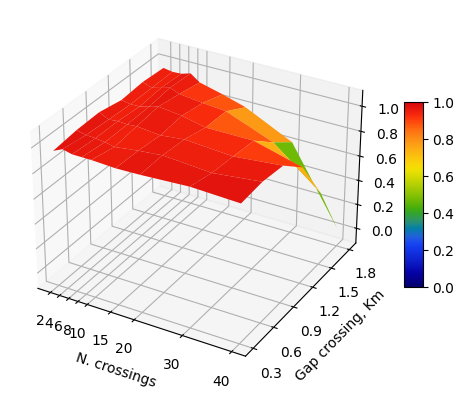

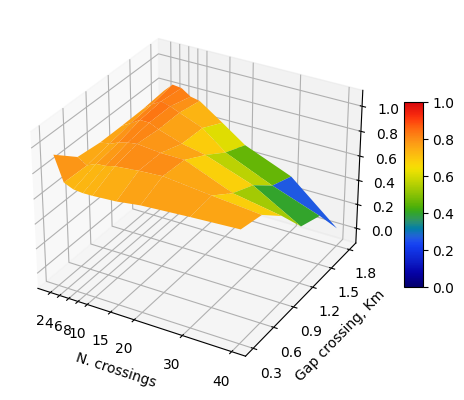

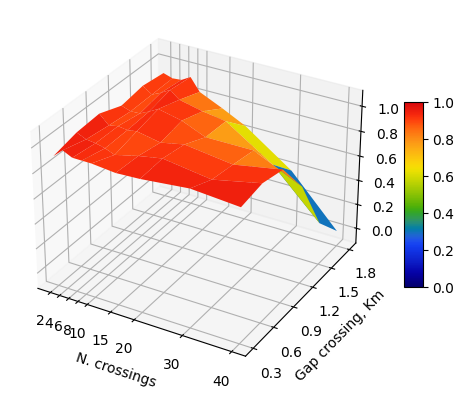

Location Correlation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.957852,0.991462,0.973066,0.972701,0.972295,0.962392,0.966859,0.985999,0.970844
2,0.981690,0.964475,0.959607,0.949919,0.933722,0.957287,0.974711,0.946376,0.988399
3,0.988463,0.950779,0.958484,0.952916,0.958706,0.939251,0.959038,0.932299,0.968250
4,0.952902,0.939571,0.941386,0.959853,0.980732,0.958971,0.916425,0.916244,0.812933
5,0.968607,0.941660,0.959709,0.981293,0.950706,0.928018,0.911847,0.765120,0.466552
6,0.956229,0.943662,0.947044,0.969413,0.915207,0.867254,0.811642,0.629418,0.024502


Explained variation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.928323,0.731855,0.700202,0.692844,0.694353,0.705765,0.731627,0.755270,0.775048
2,0.770109,0.724484,0.758344,0.763775,0.782323,0.801273,0.813106,0.772326,0.734951
3,0.747341,0.758082,0.788074,0.808374,0.820450,0.800461,0.798550,0.644953,0.576508
4,0.746622,0.787312,0.833395,0.832623,0.799089,0.735913,0.697648,0.562385,0.342648
5,0.749998,0.808020,0.851002,0.830697,0.799539,0.725944,0.578516,0.415155,0.277865
6,0.766898,0.839102,0.830099,0.779497,0.763720,0.634346,0.500179,0.346310,0.022620


Coefficient of determination:


,2,4,6,8,10,15,20,30,40
1,0.917480,0.982997,0.946858,0.946147,0.945357,0.926199,0.934816,0.972193,0.942539
2,0.963716,0.930212,0.920845,0.902346,0.871838,0.916398,0.950062,0.895628,0.976933
3,0.977059,0.903980,0.918692,0.908048,0.919117,0.882192,0.919753,0.869182,0.937508
4,0.908022,0.882793,0.886207,0.921318,0.961835,0.919625,0.839835,0.839503,0.660859
5,0.938199,0.886724,0.921041,0.962936,0.903842,0.861217,0.831464,0.585408,0.217671
6,0.914374,0.890498,0.896892,0.939762,0.837604,0.752130,0.658762,0.396167,0.000600


In [10]:
plot_bird_correlation("acowoo", max_checklists=100)

Locations in habitat: 6818 locations considered: 6730


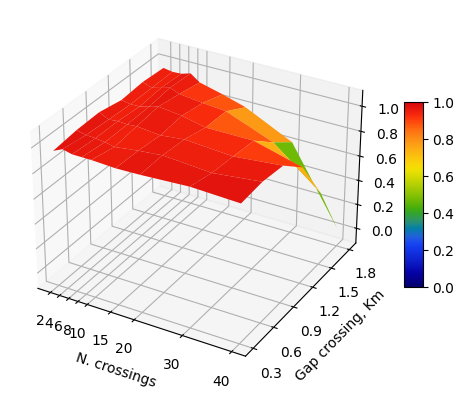

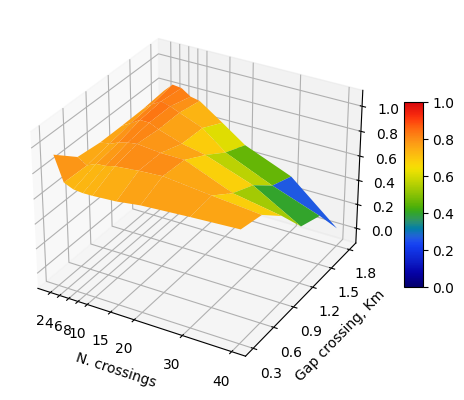

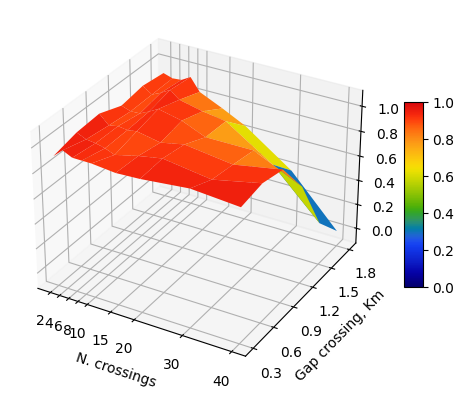

Location Correlation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.957852,0.991462,0.973066,0.972701,0.972295,0.962392,0.966859,0.985999,0.970844
2,0.981690,0.964475,0.959607,0.949919,0.933722,0.957287,0.974711,0.946376,0.988399
3,0.988463,0.950779,0.958484,0.952916,0.958706,0.939251,0.959038,0.932299,0.968250
4,0.952902,0.939571,0.941386,0.959853,0.980732,0.958971,0.916425,0.916244,0.812933
5,0.968607,0.941660,0.959709,0.981293,0.950706,0.928018,0.911847,0.765120,0.466552
6,0.956229,0.943662,0.947044,0.969413,0.915207,0.867254,0.811642,0.629418,0.024502


Explained variation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.928323,0.731855,0.700202,0.692844,0.694353,0.705765,0.731627,0.755270,0.775048
2,0.770109,0.724484,0.758344,0.763775,0.782323,0.801273,0.813106,0.772326,0.734951
3,0.747341,0.758082,0.788074,0.808374,0.820450,0.800461,0.798550,0.644953,0.576508
4,0.746622,0.787312,0.833395,0.832623,0.799089,0.735913,0.697648,0.562385,0.342648
5,0.749998,0.808020,0.851002,0.830697,0.799539,0.725944,0.578516,0.415155,0.277865
6,0.766898,0.839102,0.830099,0.779497,0.763720,0.634346,0.500179,0.346310,0.022620


Coefficient of determination:


,2,4,6,8,10,15,20,30,40
1,0.917480,0.982997,0.946858,0.946147,0.945357,0.926199,0.934816,0.972193,0.942539
2,0.963716,0.930212,0.920845,0.902346,0.871838,0.916398,0.950062,0.895628,0.976933
3,0.977059,0.903980,0.918692,0.908048,0.919117,0.882192,0.919753,0.869182,0.937508
4,0.908022,0.882793,0.886207,0.921318,0.961835,0.919625,0.839835,0.839503,0.660859
5,0.938199,0.886724,0.921041,0.962936,0.903842,0.861217,0.831464,0.585408,0.217671
6,0.914374,0.890498,0.896892,0.939762,0.837604,0.752130,0.658762,0.396167,0.000600


Locations in habitat: 5806 locations considered: 5745


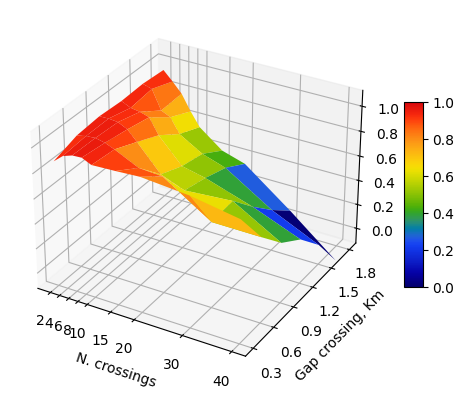

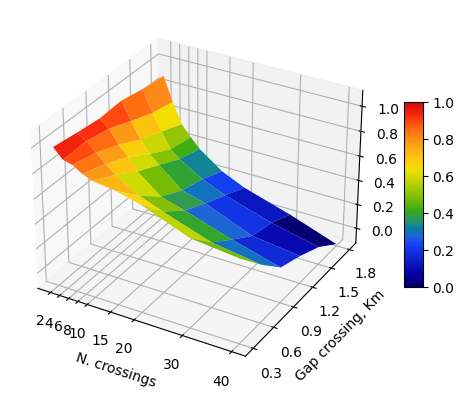

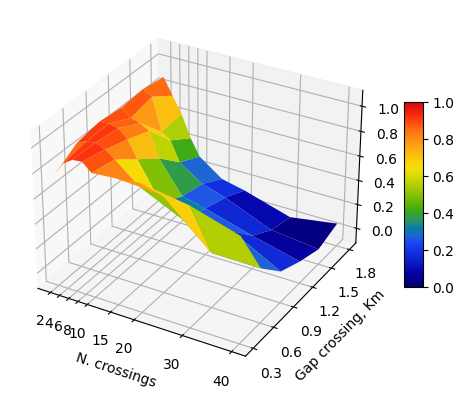

Location Correlation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.876418,0.938584,0.964440,0.968503,0.933602,0.941152,0.951344,0.917977,0.852060
2,0.939473,0.956195,0.961838,0.945073,0.914544,0.823657,0.809935,0.565120,0.562245
3,0.956128,0.958100,0.950343,0.913852,0.835206,0.629882,0.556174,0.583124,0.363003
4,0.945177,0.910741,0.898465,0.875261,0.751407,0.554286,0.511851,0.388211,0.236828
5,0.953862,0.932409,0.777071,0.742834,0.625406,0.514174,0.452002,0.213023,0.036908
6,0.939270,0.864777,0.783981,0.657524,0.546784,0.402252,0.344182,0.057256,-0.251425


Explained variation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.987440,0.909527,0.890546,0.843362,0.811982,0.787680,0.739012,0.592094,0.550282
2,0.960397,0.915729,0.847445,0.779646,0.714458,0.604410,0.533212,0.404145,0.346139
3,0.938030,0.878470,0.771450,0.695753,0.598975,0.449235,0.393802,0.272070,0.164834
4,0.948563,0.805620,0.675042,0.579183,0.510889,0.355852,0.303622,0.149484,0.101083
5,0.912653,0.735673,0.604703,0.478640,0.417632,0.303712,0.224584,0.105600,0.019463
6,0.891545,0.697797,0.531055,0.442862,0.363979,0.227397,0.141421,0.024708,-0.110586


Coefficient of determination:


,2,4,6,8,10,15,20,30,40
1,0.768109,0.880940,0.930145,0.937997,0.871613,0.885767,0.905056,0.842681,0.726006
2,0.882610,0.914309,0.925132,0.893163,0.836391,0.678411,0.655994,0.319361,0.316119
3,0.914182,0.917956,0.903151,0.835126,0.697569,0.396752,0.309329,0.340034,0.131771
4,0.893359,0.829450,0.807240,0.766082,0.564613,0.307233,0.261992,0.150708,0.056088
5,0.909853,0.869387,0.603840,0.551802,0.391133,0.264375,0.204306,0.045379,0.001362
6,0.882229,0.747840,0.614626,0.432338,0.298973,0.161806,0.118461,0.003278,0.063214


Locations in habitat: 5973 locations considered: 5891


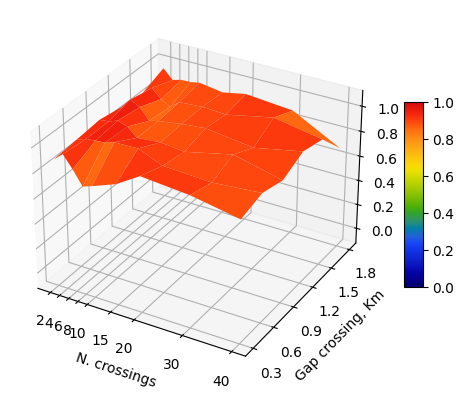

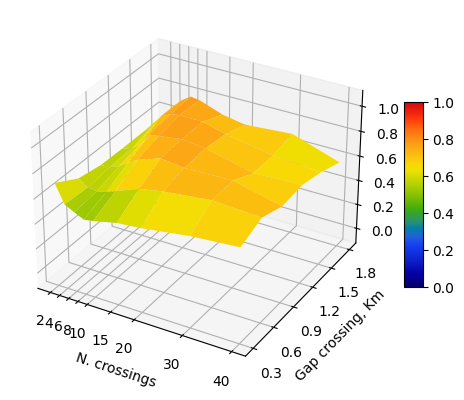

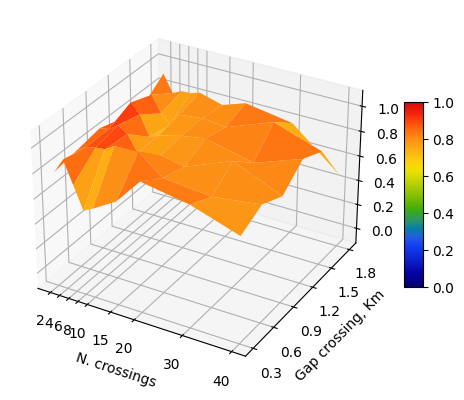

Location Correlation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.889676,0.953989,0.856544,0.744382,0.770025,0.840106,0.956260,0.921751,0.850982
2,0.908730,0.933140,0.941211,0.945869,0.969879,0.974582,0.893930,0.873145,0.902801
3,0.927924,0.935479,0.962318,0.936316,0.867313,0.884267,0.862366,0.947080,0.855433
4,0.896888,0.975464,0.937059,0.846924,0.865560,0.893563,0.910866,0.860949,0.937430
5,0.882090,0.940423,0.868102,0.827057,0.884633,0.897178,0.885190,0.962638,0.893374
6,0.953514,0.877409,0.897089,0.899074,0.912184,0.883173,0.919248,0.885251,0.684899


Explained variation, max checklists = 100:


,2,4,6,8,10,15,20,30,40
1,0.706745,0.558640,0.519561,0.483781,0.495428,0.537155,0.553906,0.608046,0.638025
2,0.598613,0.548167,0.539810,0.555688,0.586207,0.658085,0.693519,0.736243,0.714388
3,0.564590,0.570639,0.598386,0.649247,0.691653,0.757294,0.735484,0.743646,0.653424
4,0.560911,0.582175,0.635175,0.731794,0.745470,0.772141,0.751845,0.659911,0.674236
5,0.563079,0.625107,0.730225,0.765342,0.780366,0.776508,0.727816,0.659021,0.633904
6,0.575095,0.659926,0.729544,0.779827,0.769156,0.701966,0.668017,0.697617,0.570213


Coefficient of determination:


,2,4,6,8,10,15,20,30,40
1,0.791523,0.910095,0.733667,0.554105,0.592938,0.705778,0.914432,0.849625,0.724170
2,0.825790,0.870750,0.885878,0.894668,0.940664,0.949811,0.799110,0.762383,0.815050
3,0.861043,0.875121,0.926057,0.876689,0.752232,0.781928,0.743675,0.896960,0.731765
4,0.804408,0.951529,0.878079,0.717280,0.749195,0.798455,0.829677,0.741233,0.878774
5,0.778083,0.884396,0.753601,0.684024,0.782575,0.804929,0.783561,0.926672,0.798117
6,0.909189,0.769847,0.804770,0.808334,0.832079,0.779995,0.845017,0.783670,0.469087


In [11]:
for bird in ["acowoo", "stejay", "oaktit308"]:
    plot_bird_correlation(bird)

In [12]:
def plot_bird_confidence(bird_nickname, hop_distance=4, spreads=8):
    corrZ = np.zeros_like(surfX)
    for bird in birds:
        if bird.nickname == bird_nickname and bird.hop_distance == hop_distance and bird.num_spreads == spreads:
            bird_name = bird.name
            df = pd.read_csv(bird.obs_csv_path)
            print("Read", len(df), "observations")
            df = df.loc[lambda r : r["max_hab"] > 0.5] # It goes from 0 to 255 (in fact, it's only either 0 or 255).
            print("of which", len(df), "are touching habitat")
            df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
            display(df.groupby("MaxRepopRange")["Square"].count())
    return df

In [13]:
def plot_bird_ratios_checklists(bird_nickname, hop_distance=2, spreads=2):
    corrZ = np.zeros_like(surfX)
    for bird in birds:
        if bird.nickname == bird_nickname and bird.hop_distance == hop_distance and bird.num_spreads == spreads:
            bird_name = bird.name
            df = pd.read_csv(bird.obs_csv_path)
            # limit to squares where max hab > 0.9
            df = df.loc[lambda r : r["max_hab"] > 0.9]
            df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
            tot_checklists = np.array(df.groupby("MaxRepopRange")["NumChecklists"].sum())
            tot_birds = np.array(df.groupby("MaxRepopRange")["NumBirds"].sum())
            ys = tot_birds / tot_checklists
            xs = list(df.groupby("MaxRepopRange")["NumBirds"].indices.keys())
            fig, ax = plt.subplots()
            ax.scatter(xs, ys, s=tot_checklists / 10., alpha=0.5)
            ax.set_xlabel("Repopulation")
            ax.set_ylabel("Average sightings per checklist")
            ax.set_title("{}, dispersal flight {}m, range {} Km".format(
                bird.name, hop_distance * 300, spreads * hop_distance * 300 / 1000))
            ax.set_xlim((-0.05, 1))
            ymin, ymax = np.min(ys), np.max(ys)
            ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
            ax.set_ylim((ylmin, ylmax))

            ax.grid(True)
            fig.tight_layout()

            plt.show()

In [14]:
def plot_bird_ratios_locations(bird_nickname, hop_distance=2, spreads=2, max_checklists=100):
    corrZ = np.zeros_like(surfX)
    for bird in birds:
        if bird.nickname == bird_nickname and bird.hop_distance == hop_distance and bird.num_spreads == spreads:
            bird_name = bird.name
            df = pd.read_csv(bird.obs_csv_path)
            # limit to squares where max hab > 0.9
            df = df.loc[lambda r : r["max_hab"] > 0.9]
            df = df.loc[lambda r : r["NumChecklists"] <= max_checklists]
            df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
            sizes = np.array(df.groupby("MaxRepopRange")["Square"].count()) # Counts the locations. 
            ys = np.array(df.groupby("MaxRepopRange")["BirdRatio"].mean())
            xs = np.array(list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys()))
            corr = wcorr(xs, ys, sizes)
            print("Correlation:", corr)
            reg = LinearRegression().fit(xs.reshape(-1, 1), ys.reshape(-1, 1), sizes)
            r_square = reg.score(xs.reshape(-1, 1), ys.reshape(-1, 1), sizes)
            print("R^2:", r_square)
            norm = plt.Normalize(vmin=min(sizes), vmax=max(sizes))
            fig, ax = plt.subplots()
            ax.scatter(xs, ys, s=sizes, alpha=0.5)
            ax.set_xlabel("Repopulation")
            ax.set_ylabel("Average sightings per checklist")
            ax.set_title("{}, gap crossing {}m, range {} Km".format(
                bird.name, hop_distance * 300, spreads * hop_distance * 300 / 1000))
            ax.set_xlim((-0.05, 1))
            ymin, ymax = np.min(ys), np.max(ys)
            ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
            ax.set_ylim((ylmin, ylmax))

            ax.grid(True)
            fig.tight_layout()
            print("Average on locations with max {} checklists".format(max_checklists))
            plt.show()

Correlation: 0.974582484186819
R^2: 0.9498110184837513
Average on locations with max 100 checklists


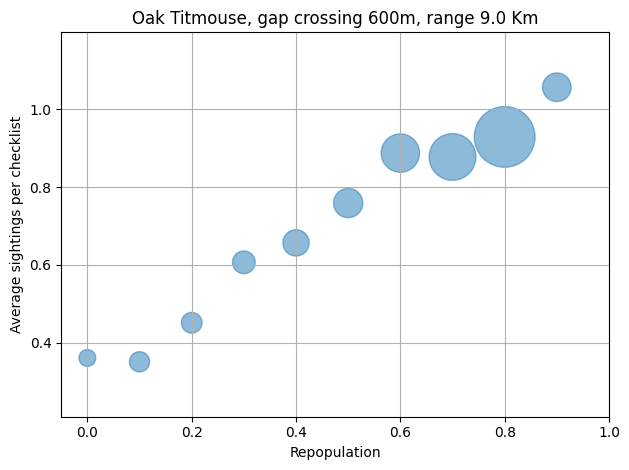

In [15]:
plot_bird_ratios_locations("oaktit308", hop_distance=2, spreads=15)


Correlation: 0.9618377974105832
R^2: 0.9251319485276421
Average on locations with max 100 checklists


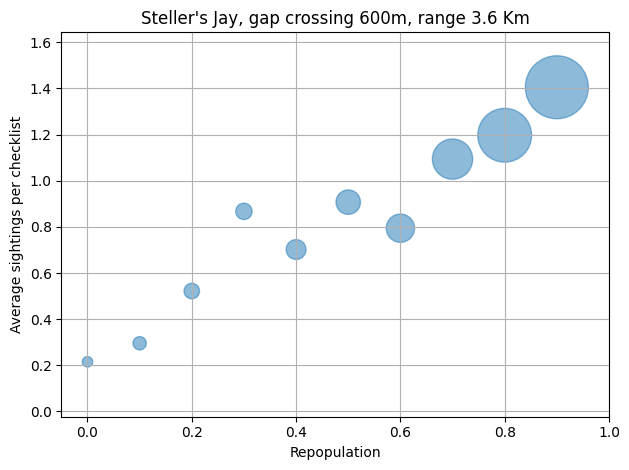

In [16]:
plot_bird_ratios_locations("stejay", hop_distance=2, spreads=6)


Correlation: 0.9747110393505286
R^2: 0.9500616102317876
Average on locations with max 100 checklists


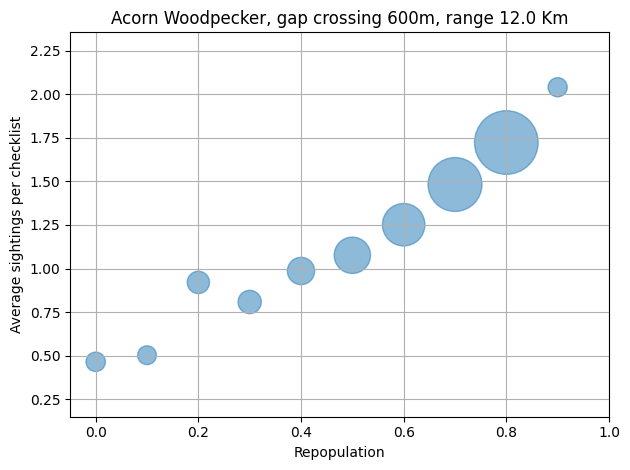

In [17]:
plot_bird_ratios_locations("acowoo", hop_distance=2, spreads=20)
# YES


Make scatterplot of correlation between maxrepop and birdratios for our birds of interest:


In [18]:
birds_for_paper = []

# acorn woodpecker, hop distance = 2, num spreads = 20
birds_for_paper.append(bird_run.get_bird_run(
    "acowoo", "Acorn Woodpecker",
    do_validation=False, run_name="Jun8",
    hop_distance=2, num_spreads=20,
    num_simulations=NUM_SIMULATIONS,
    transmission_exponent=TRANSMISSION_EXPONENT))

# Steller's Jay, hop distance = 2, num spreads = 4
birds_for_paper.append(bird_run.get_bird_run(
    "stejay", "Steller's Jay",
    do_validation=False, run_name="Jun8",
    hop_distance=2, num_spreads=6,
    num_simulations=NUM_SIMULATIONS,
    transmission_exponent=TRANSMISSION_EXPONENT))

# Oak Titmouse
birds_for_paper.append(bird_run.get_bird_run(
    "oaktit308", "Oak Titmouse",
    do_validation=True, run_name="Jun8",
    hop_distance=2, num_spreads=15,
    num_simulations=NUM_SIMULATIONS,
    transmission_exponent=TRANSMISSION_EXPONENT))


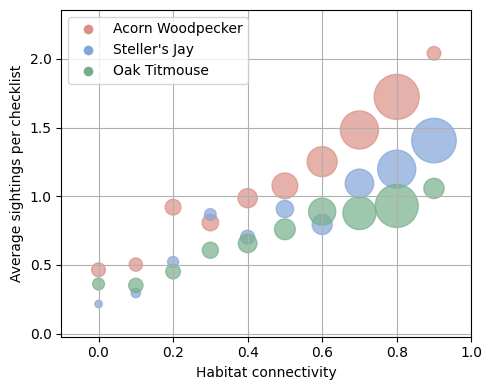

In [19]:


from matplotlib.lines import Line2D  # for legend handle
def plot_birds_ratios(bird_ls, path, max_checklists=100):
    fig, ax = plt.subplots(figsize=(5, 4))

    cmap = colorcet.cm.cyclic_isoluminant_r
    # cmap = plt.cm.inferno
    unique_birds = list(b.nickname for b in bird_ls)
    num_birds = len(unique_birds)
    colors = cmap(np.linspace(0, 1 - 1/num_birds, num_birds))
    colormap = {b:c for b, c in zip(unique_birds, colors)}
    birdname = {b.nickname: b.name for b in bird_ls}
    ylimits = []
    for bird in bird_ls:
        bird_nickname = bird.nickname
        df = pd.read_csv(bird.obs_csv_path)
        # limit to squares where max hab > 0.9
        df = df.loc[lambda r : r["max_hab"] > 0.9]
        df = df.loc[lambda r : r["NumChecklists"] <= max_checklists]
        df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
        sizes = np.asarray(df.groupby("MaxRepopRange")["Square"].count())
        ys = df.groupby("MaxRepopRange")["BirdRatio"].mean()
        xs = list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys())
        ymin, ymax = np.min(ys), np.max(ys)
        ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
        ylimits.append((ylmin, ylmax))
        volume = sizes / 2
        # volume = np.sqrt(sizes**3 / max(sizes))

        ax.scatter(xs, ys, s=volume, color=colormap[bird_nickname], alpha=0.7, label=bird.name)

    ax.set_xlabel("Habitat connectivity")
    ax.set_ylabel("Average sightings per checklist")
    # ax.set_title('Bird sightings vs. connectivity')

    ax.grid(True)
    fig.tight_layout()

    # add a legend
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, label=birdname[b], markersize=8) for b, c in colormap.items()]
    ax.legend(handles=handles, loc='upper left')
    plt.xlim((-0.1, 1.0))
    yls, yhs = zip(*ylimits)
    ax.set_ylim(min(yls), max(yhs))

    plt.show()
    
    # fig.savefig("SightingsVsConnectivity.pdf", format="pdf")

plot_birds_ratios(birds_for_paper, "./corr_by_vol.jpg")